# Tensorflow RNN on a GPU

Goal: design a recurrent neural Network in Tensorflow and train it on a Colab GPU. 


In [1]:
# -*- coding: utf-8 -*-
"""
Create first LSTM prediction system in Tensorflow to train on GPU

"""

'\nCreate first LSTM prediction system in Tensorflow to train on GPU\n\n'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

TensorFlow 2.x selected.


Next, we need to connect to a Colab GPU

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Loading and preprocessing data

In [3]:
!pip install quandl

  Created wheel for inflection: filename=inflection-0.3.1-cp36-none-any.whl size=6077 sha256=540e9fb6ef7e956d534b91895ee6503ab0141009d5144dd5b408881217def287
  Stored in directory: /root/.cache/pip/wheels/9f/5a/d3/6fc3bf6516d2a3eb7e18f9f28b472110b59325f3f258fe9211
Successfully built inflection


In [0]:
import quandl
from dataprep_class import Dataprep

In [6]:
quandl.ApiConfig.api_key = "Ha9a4yRKHowJC_sQxSPD"
data = quandl.get("EIA/PET_RWTC_D")
print(data.head())
print(data.shape)

            Value
Date             
1986-01-02  25.56
1986-01-03  26.00
1986-01-06  26.53
1986-01-07  25.85
1986-01-08  25.87
(8639, 1)


In [0]:
# use methods from data_import.py
data = data.iloc[::-1]
data = data.reset_index()
data.drop('Date', axis = 1, inplace = True)

data = data.to_numpy()
prices = np.delete(data, obj =  0, axis = 1)

(8639, 1)


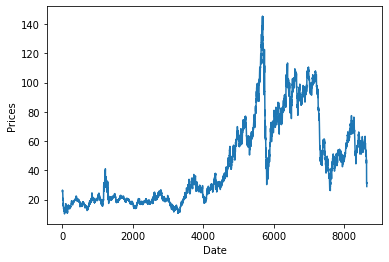

In [8]:
print(data.shape)
prices = np.flip(data, axis = 0)
plt.plot(prices[:,0])
plt.xlabel("Date")
plt.ylabel("Prices")
plt.show()

In [9]:
prep = Dataprep()
scaled_data, scaler = prep.scaling(prices, "MinMax")

x_train , y_train = prep.sliding_windows(scaled_data, wsize = 60, stepsize = 1)

x_train, y_train, x_test, y_test, x_val, y_val = prep.train_test_split(x_train, y_train, train_percent = 0.8, validation = True, val_percent = 0.1)

x_train = prep.rnn_reshape(x_train)
x_test = prep.rnn_reshape(x_test)
x_val = prep.rnn_reshape(x_val)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(6862, 60, 1) (6862, 1) (859, 60, 1) (859, 1)


# Build Neural Network

In [0]:
class gru():
    """ class to clean up keras lstm structure and advance training """

    def build(self, layers, units, timesteps, loss = 'mean_squared_error', dropout = True, l2_reg = False, dropout_rate = 0.2):
        """
        Parameters
        ----------
        layers : integer - how many LSTM layers to use
        units : integer - how many units per LSTM layer
        timesteps : x_train.shape[1] (time steps per input frame)
        loss : loss function
        dropout : bool - use dropout or not
        l2_reg : bool - use L2 regularization or not
        dropout_rate : float between zero and one
        -------
        returns: compiled LSTM model
        """
        if layers <= 0 or units <= 0:
            raise ValueError("layers and units cannot be smaller or equal to zero")
        
        if 0 > dropout_rate or dropout_rate > 1:
            raise ValueError("dropout rate must be between zero and 1")

        if l2_reg:
            reg = keras.regularizers.l2(0.001)
        else:
            reg = None

        if not dropout:
            dropout_rate = 0
        

        model = keras.models.Sequential()

        if layers == 1:
            model.add(keras.layers.GRU(units = 50, return_sequences = False, kernel_regularizer = reg, input_shape = (timesteps, 1))) 
            model.add(keras.layers.Dropout(dropout_rate))
        

        else:
            model.add(keras.layers.GRU(units = 50, return_sequences = True, kernel_regularizer = reg, input_shape = (timesteps, 1))) 
            model.add(keras.layers.Dropout(dropout_rate))

            for i in range(layers - 2):
                model.add(keras.layers.GRU(units = 50, return_sequences = True, kernel_regularizer = reg)) 
                model.add(keras.layers.Dropout(dropout_rate))
            
            model.add(keras.layers.GRU(units = 50, return_sequences = False, kernel_regularizer = reg)) 
            model.add(keras.layers.Dropout(dropout_rate))

        model.add(keras.layers.Dense(1, activation = 'relu'))

        optimizer = keras.optimizers.Adam(learning_rate = 0.0075, epsilon = 1e-08)
        model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

        return model



# Training the Network

In [13]:
timesteps = x_train.shape[1]

gru1 = gru()

# build model 1 with 3 layer and 50 units, dropout 0.2, not L2 reg
model = gru1.build(3, 50, timesteps)

tb_callback = keras.callbacks.TensorBoard(histogram_freq = 1)

model.fit(x_train, y_train, epochs = 75, validation_data = (x_val, y_val), callbacks = [tb_callback])

Train on 6862 samples, validate on 857 samples
Epoch 1/75
6862/6862 [==============================] - 7s 972us/sample - loss: 0.0045 - accuracy: 2.9146e-04 - val_loss: 2.7218e-04 - val_accuracy: 0.0000e+00
Epoch 2/75
6862/6862 [==============================] - 4s 519us/sample - loss: 0.0012 - accuracy: 2.9146e-04 - val_loss: 2.0240e-04 - val_accuracy: 0.0000e+00
Epoch 3/75
6862/6862 [==============================] - 4s 532us/sample - loss: 9.2162e-04 - accuracy: 2.9146e-04 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 4/75
6862/6862 [==============================] - 4s 537us/sample - loss: 9.4321e-04 - accuracy: 2.9146e-04 - val_loss: 1.9737e-04 - val_accuracy: 0.0000e+00
Epoch 5/75
6862/6862 [==============================] - 4s 525us/sample - loss: 7.5797e-04 - accuracy: 2.9146e-04 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 6/75
6862/6862 [==============================] - 4s 540us/sample - loss: 7.2707e-04 - accuracy: 2.9146e-04 - val_loss: 0.0010 - val_accuracy: 

In [15]:
%load_ext tensorboard
%tensorboard --logdir logs/

<IPython.core.display.Javascript object>

# Evaluating the Network

In [0]:
from Myplot_class import Myplot
myplt = Myplot()

In [0]:
indices = [243,217,100,500,400,6]
x_real = prep.rnn_reshape(x_train, to_rnn=False)
x_test_real = prep.rnn_reshape(x_test, to_rnn=False)

x_real = prep.inverse_scaling(x_real, scaler)
y_real = prep.inverse_scaling(y_train, scaler)
x_test_real = prep.inverse_scaling(x_test_real, scaler)
y_test_real = prep.inverse_scaling(y_test, scaler)

predictions = model.predict(x_test)
predictions = prep.inverse_scaling(predictions, scaler)


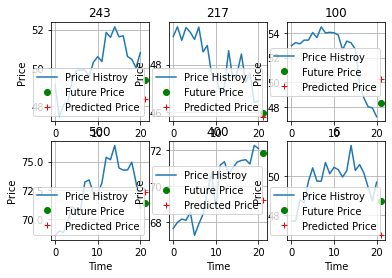

In [20]:
myplt.pred_examples(x_test_real, y_test_real, predictions, indices)

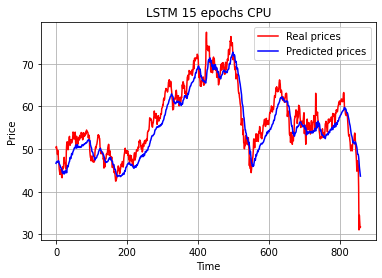

In [21]:
myplt.real_vs_pred(y_test_real, predictions, "LSTM 15 epochs CPU")